In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(4060)

In [2]:
# 产生均衡的逻辑回归数据
n = 2000
cov = [[1, 0], [0, 1]]
X = np.random.multivariate_normal([0, 0], cov, n)
beta = np.array([1, -1]).reshape(2, 1)
error = np.random.logistic(size=n).reshape(-1, 1)
Y = (np.dot(X, beta) + error > 0) + 0

In [3]:
def unbalanced_data(X, Y, zero_times):
    '''
    通过将类别0的数据重复zero_times次，将均衡数据集变为非均衡数据集
    '''
    X0 = np.repeat(X[np.where(Y == 0)[0]], zero_times, axis=0)
    Y0 = np.repeat(Y[np.where(Y == 0)[0]], zero_times, axis=0)
    X1 = X[np.where(Y > 0)[0]]
    Y1 = Y[np.where(Y > 0)[0]]
    _X = np.append(X0, X1, axis=0)
    _Y = np.append(Y0, Y1, axis=0)
    return _X, _Y

In [4]:
# 产生非均衡的数据
x = []
y = []
for zero_times in np.arange(1, 100):
    _X, _Y = unbalanced_data(X, Y, zero_times)
    x.append(_X)
    y.append(_Y)

In [5]:
def evaluate_model(Y, pred):
    '''
    评估模型效果，其中包括ACC，AUC以及预测结果中类别1的个数
    '''
    pred_positive = []
    true_positive = []
    aucs = []
    accuracies = []
    ratios = []
    for i in range(len(Y)):
        ratios.append(len(Y[i][Y[i] > 0]) / float(len(Y[i])))
        pred_positive.append(len(pred[i][pred[i] > 0]))
        true_positive.append(len(Y[i][Y[i] > 0]))
        fpr, tpr, _ = metrics.roc_curve(Y[i], pred[i])
        accuracies.append(metrics.accuracy_score(Y[i], pred[i]))
        aucs.append(metrics.auc(fpr, tpr))
    return visualize(ratios, pred_positive, true_positive, aucs, accuracies)

In [6]:
def visualize(ratios, pred_positive, true_positive, aucs, accuracies):
    '''
    将模型结果可视化
    '''
    # 为在Matplotlib中显示中文，设置特殊字体
    plt.rcParams['font.sans-serif'] = ['SimHei']
    # 正确显示负号
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams.update({'font.size': 13})
    # 创建一个图形框
    fig = plt.figure(figsize=(12, 6), dpi=100)
    # 在图形框里画两幅图
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(ratios, pred_positive, label='%s' % '预测结果里类别1的个数')
    ax.plot(ratios, true_positive, 'k--', label='%s' % '原始数据里类别1的个数')
    ax.set_xlim([0, 0.5])
    ax.invert_xaxis()
    legend = plt.legend(shadow=True, loc='best')
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.plot(ratios, aucs, 'r', label='%s' % '曲线下面积（AUC）')
    ax1.plot(ratios, accuracies, 'k-.', label='%s' % '准确度（ACC）')
    ax1.set_xlim([0, 0.5])
    ax1.set_ylim([0.5, 1])
    ax1.invert_xaxis()
    legend = plt.legend(shadow=True, loc='best')
    return fig

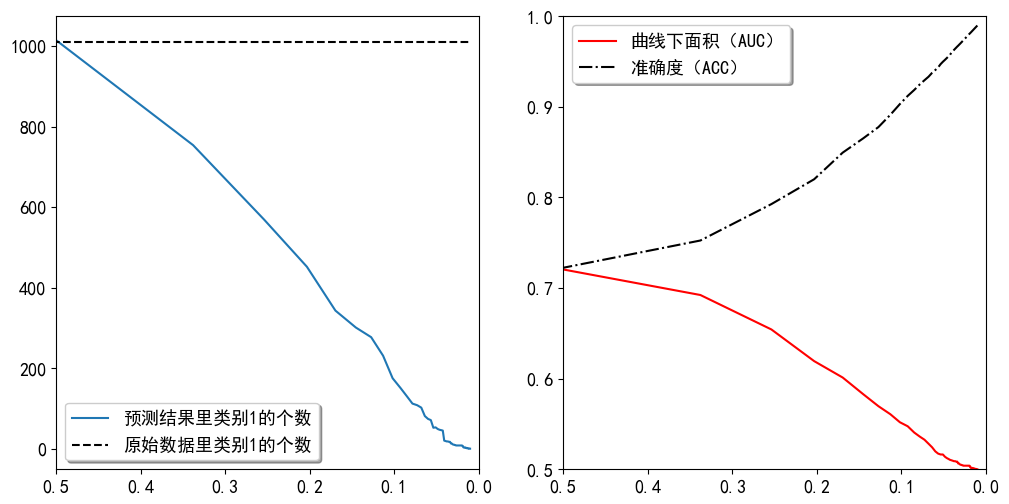

In [7]:
pred_y = []

for _x, _y in zip(x, y):
    # 为了消除惩罚项的干扰，将惩罚系数设为很大
    model = LogisticRegression(C=1e4)
    model.fit(_x, _y.ravel())
    pred_y.append(model.predict(_x))

re = evaluate_model(y, pred_y)
re.savefig('imbalanced_data.png', dpi=200)
plt.show()

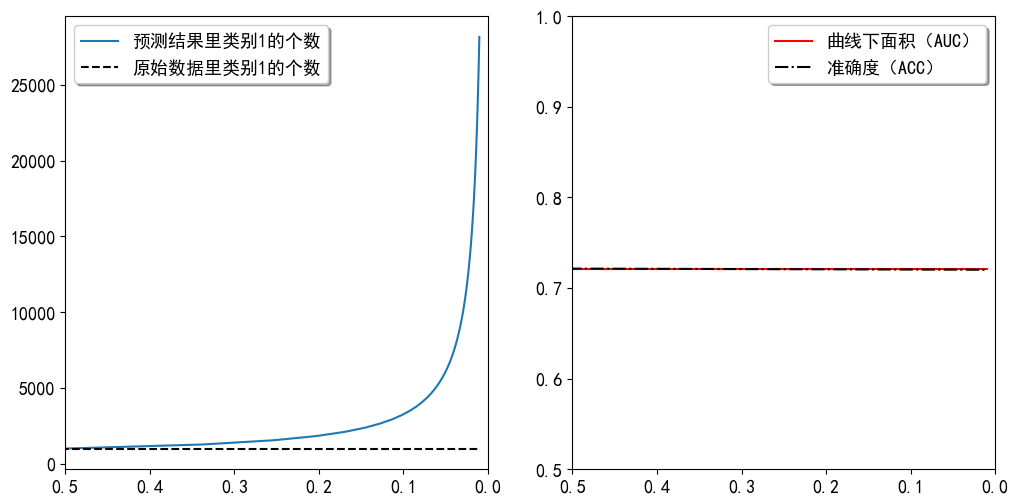

In [8]:
balanced_pred_y = []

for _x, _y in zip(x, y):
    positive_weight = len(_y[_y > 0]) / float(len(_y))
    class_weight = {1: 1. / positive_weight, 0: 1. / (1 - positive_weight)}
    # 为了消除惩罚项的干扰，将惩罚系数设为很大
    model = LogisticRegression(class_weight=class_weight, C=1e4)
    model.fit(_x, _y.ravel())
    balanced_pred_y.append(model.predict(_x))

re = evaluate_model(y, balanced_pred_y)
re.savefig('imbalanced_data_solution.png', dpi=200)
plt.show()